In [1]:
import numpy as np
import matplotlib.pyplot as plt
from noise_generator import GenerateNoise
import qutip as qt
from hamiltonian_generator import Hamiltonian

Sanity Checks (1/f noise):
PSD fit: power = -0.9999, intercept = -4.5599, R² = 0.9990, S0 = 2.094012e-03


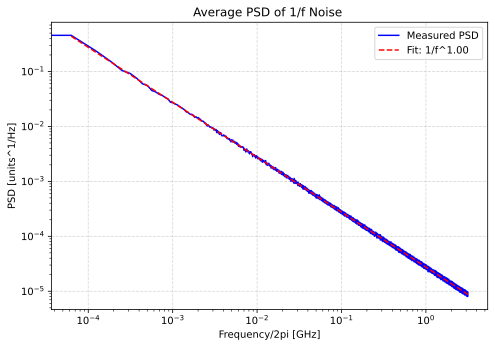

In [2]:
sample_rate = 1               # per ns
tnoise_max = int(1e5)             # number of samples
omega_ir = 1/tnoise_max*2*np.pi
S0 = 1e-2
relative_PSD_strength = S0**2
num_realizations = 1000
ifwhite = False               # True for white noise, False for 1/f noise
# Generate white noise (unit variance) trajectories
N = tnoise_max * sample_rate
gn = GenerateNoise(sample_rate, tnoise_max, relative_PSD_strength, num_realizations, ifwhite)
trajs = gn.generate_colored_noise()
S0 = gn.analyze_noise_psd(trajs)

In [3]:
phi_ex = 0.2
Ej = 30.19 
Ec = 0.1
sc = Hamiltonian(phi_ex, Ej, Ec, [5,3])
H0 = qt.Qobj(sc.H)
H_control = qt.Qobj(sc.H_control)
A = 0e-3 * 2 * np.pi
optimal_omega = sc.optimal_omegad(A)[0]*2*np.pi

initial_state, state_and_sigmax, get_projector = sc.setup_floquet_system(A,optimal_omega)
noise = sc.noise
# (np.cos(phi_ex*np.pi)*(np.cos(trajectory*np.pi)-1) - np.sin(phi_ex*np.pi)*np.sin(trajectory*np.pi))
dim = noise.shape[0]

In [4]:
from joblib import Parallel, delayed
# Initialize arrays to store results
all_expect_values = []
t_max = 100
N = 2*t_max
time_points = np.linspace(0, t_max, N)  # Time points matching noise trajectory
initial_state = qt.Qobj(initial_state)
noise = qt.Qobj(noise)

def process_trajectory(i):
    # Create time-dependent Hamiltonian with noise trajectory
    H = [H0, 
         [H_control, lambda t, args: A * np.cos(optimal_omega * t)], 
         [noise, lambda t, args: trajs[i][int(t * sample_rate)] if t < t_max else 0]]
    
    # Solve the dynamics
    result = qt.sesolve(H, initial_state, time_points)
    
    # Calculate projector averages for each time point
    avg_values = np.zeros((dim+1, len(time_points)))
    for j, t in enumerate(time_points):
        state_t = result.states[j]
        U, sigmax = state_and_sigmax(t)
        projectors = get_projector(U)
        avg_values[0, j] = qt.expect(qt.Qobj(sigmax), state_t)
        # Calculate the average of the projectors
        for k in range(dim):
            avg_values[k+1, j] = qt.expect(qt.Qobj(projectors[k]), state_t)
    return avg_values

# Parallelize the computation with joblib
all_expect_values = Parallel(n_jobs=-1)(delayed(process_trajectory)(i) for i in range(num_realizations))



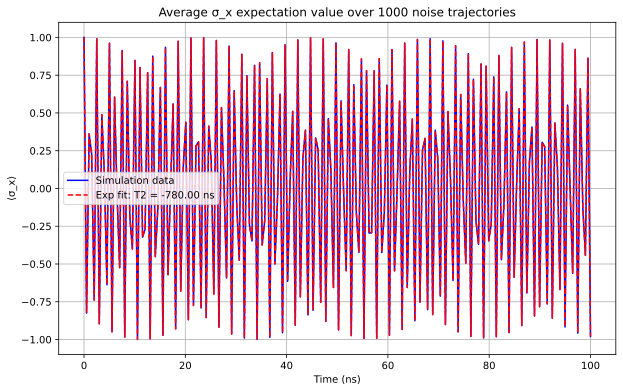

Fitted T2 time = -780.0012 ns


In [5]:
all_expect_values = np.array(all_expect_values)
# Calculate the average and standard deviation
avg_values = np.mean(all_expect_values, axis=0)


# Define exponential decay function for fitting
def exp_decay(t, T2, omega):
    return np.exp(-t**2 / T2**2) * np.cos(omega * t)

# Fit the data with exponential decay (fitting both T2 and omega)
from scipy.optimize import curve_fit
params, pcov = curve_fit(exp_decay, time_points, avg_values[0], p0=[5000, sc.omega_c - optimal_omega],)
T2_fit, omega_fit = params

# Plot the results with the fit
plt.figure(figsize=(10, 6))
plt.plot(time_points, avg_values[0] , 'b-', label='Simulation data')
plt.plot(time_points, exp_decay(time_points, T2_fit,omega_fit), 'r--', 
         label=f'Exp fit: T2 = {T2_fit:.2f} ns')
plt.xlabel('Time (ns)')
plt.ylabel('⟨σ_x⟩')
plt.title(f'Average σ_x expectation value over {num_realizations} noise trajectories')
plt.legend()
plt.grid(True)
plt.show()

# Print the fitted parameters
print(f"Fitted T2 time = {T2_fit:.4f} ns")

In [6]:
phi_ex = 0.2
Ej = 30.19 
Ec = 0.1
sc = Hamiltonian(phi_ex, Ej, Ec, [5,3])
H0 = qt.Qobj(sc.H)
H_control = qt.Qobj(sc.H_control)
A = 5e-3 * 2 * np.pi
optimal_omega = sc.optimal_omegad(A)[0]*2*np.pi

initial_state, state_and_sigmax, get_projector = sc.setup_floquet_system(A,optimal_omega)
noise = sc.noise
# (np.cos(phi_ex*np.pi)*(np.cos(trajectory*np.pi)-1) - np.sin(phi_ex*np.pi)*np.sin(trajectory*np.pi))
dim = noise.shape[0]

 /home/yunwei/.conda/envs/yunwei/lib/python3.11/site-packages/matplotlib/cbook.py: 1719ComplexWarning: Casting complex values to real discards the imaginary part
 /home/yunwei/.conda/envs/yunwei/lib/python3.11/site-packages/matplotlib/cbook.py: 1355

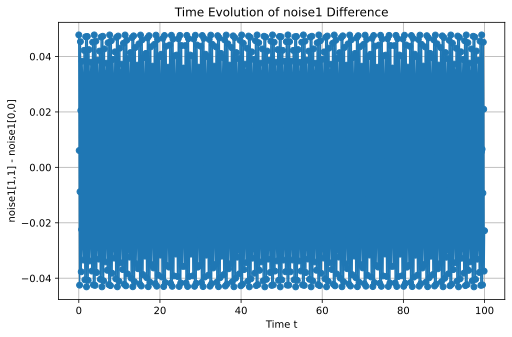

In [7]:
# Create an array of time values to sample 
t_values = np.linspace(0, t_max, 1000)
diff_vals = []

for t in t_values:
    U, _ = state_and_sigmax(t)
    Ud = U.T.conj()
    # Work with a fresh copy of noise every time
    noise = sc.noise.copy()
    np.fill_diagonal(noise, np.diag(noise) - noise[0,0])
    noise1 = Ud @ noise @ U
    # Take the real part if necessary
    diff_vals.append(noise1[1,1] - noise1[0,0])

plt.figure(figsize=(8,5))
plt.plot(t_values, diff_vals, marker='o', linestyle='-')
plt.xlabel("Time t")
plt.ylabel("noise1[1,1] - noise1[0,0]")
plt.title("Time Evolution of noise1 Difference")
plt.grid(True)
plt.show()

In [8]:
from joblib import Parallel, delayed
# Initialize arrays to store results
all_expect_values = []
t_max = 100
N = 2*t_max
time_points = np.linspace(0, t_max, N)  # Time points matching noise trajectory
initial_state = qt.Qobj(initial_state)
noise = qt.Qobj(noise)

def process_trajectory(i):
    # Create time-dependent Hamiltonian with noise trajectory
    H = [H0, 
         [H_control, lambda t, args: A * np.cos(optimal_omega * t)], 
         [noise, lambda t, args: trajs[i][int(t * sample_rate)] if t < t_max else 0]]
    
    # Solve the dynamics
    result = qt.sesolve(H, initial_state, time_points)
    
    # Calculate projector averages for each time point
    avg_values = np.zeros((dim+1, len(time_points)))
    for j, t in enumerate(time_points):
        state_t = result.states[j]
        U, sigmax = state_and_sigmax(t)
        projectors = get_projector(U)
        avg_values[0, j] = qt.expect(qt.Qobj(sigmax), state_t)
        # Calculate the average of the projectors
        for k in range(dim):
            avg_values[k+1, j] = qt.expect(qt.Qobj(projectors[k]), state_t)
    return avg_values

# Parallelize the computation with joblib
all_expect_values = Parallel(n_jobs=-1)(delayed(process_trajectory)(i) for i in range(num_realizations))



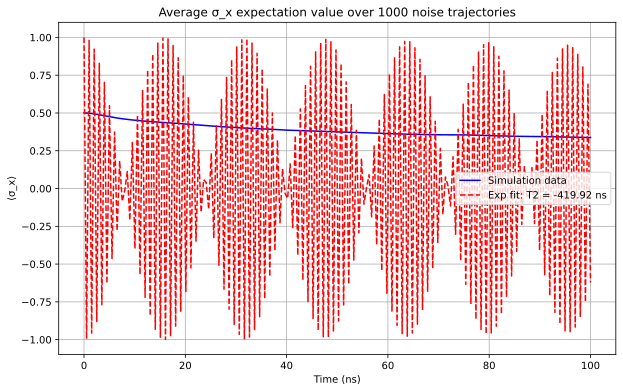

Fitted T2 time = -419.9218 ns


In [11]:
all_expect_values = np.array(all_expect_values)
# Calculate the average and standard deviation
avg_values = np.mean(all_expect_values, axis=0)


# Define exponential decay function for fitting
def exp_decay(t, T2, omega):
    return np.exp(-t**2 / T2**2) * np.cos(omega * t)

# Fit the data with exponential decay (fitting both T2 and omega)
from scipy.optimize import curve_fit
params, pcov = curve_fit(exp_decay, time_points, avg_values[0], p0=[5000, sc.omega_c - optimal_omega],)
T2_fit, omega_fit = params

# Plot the results with the fit
plt.figure(figsize=(10, 6))
plt.plot(time_points, avg_values[1] , 'b-', label='Simulation data')
plt.plot(time_points, exp_decay(time_points, T2_fit,omega_fit), 'r--', 
         label=f'Exp fit: T2 = {T2_fit:.2f} ns')
plt.xlabel('Time (ns)')
plt.ylabel('⟨σ_x⟩')
plt.title(f'Average σ_x expectation value over {num_realizations} noise trajectories')
plt.legend()
plt.grid(True)
plt.show()

# Print the fitted parameters
print(f"Fitted T2 time = {T2_fit:.4f} ns")